# From the RBM to the Generalized Ising Model

In this notebook we will present an implementation of the mapping between an Restricted Boltzmann Machines and Generalized Ising model that contains interactions up to an arbitrary number of bodies, which was introduced by in the Ref. [1].


## Introduction

Let us start with the energy function of a Restricted Boltzmann Machine (RBM):

$$
 \mathcal{H}(\boldsymbol{v}, \boldsymbol{h}) = - \sum_{i=1}^{N_h} c_i h_i  - \sum_{j=1}^{N_v} b_j v_j - \sum_{j=1}^{N_v} \sum_{i=1}^{N_h}  h_i W_{ij} v_j , \tag{1}
$$

with binary variables $v_j, h_i \in \{0, 1 \}$. By applying a change of variables and then marginalizing over the hidden nodes, one can obtain an expression for the energy solely dependent upon the visible nodes $\sigma_j \in \{ -1, 1 \}$:

$$
\begin{align}
\mathcal{H}(\boldsymbol{\sigma}) 
&= - \sum_j \left( b_j + \frac{1}{2} \sum_i W_{ij} \right) \sigma_j - \sum_i \ln \cosh \left[ \frac{1}{4} \sum_j W_{ij} \sigma_j + \frac{1}{2} \left( c_i + \frac{1}{2} \sum_j W_{ij} \right) \right] \\ 
&= - \sum_j \eta_j \sigma_j - \sum_i \ln \cosh \left( \sum_j w_{ij} \sigma_j + \theta_i \right), \tag{2}
\end{align}
$$

where the following variables were defined

$$
\eta_j \equiv \frac{1}{2} \left( b_j + \frac{1}{2} \sum_i W_{ij} \right), \ \theta_i \equiv \frac{1}{2} \left( c_i + \frac{1}{2} \sum_j W_{ij} \right), \ w_{ij} \equiv \frac{1}{4} W_{ij}. \tag{3}
$$

It can be we showed that the effective Hamiltonian given in the Eq. $(2)$ can be expanded as a Generalized Ising Model (GIM) Hamiltonian of the form
 
$$ \begin{align} 
\mathcal{H}_{\mathrm{GIM}}(\boldsymbol{\sigma}) 
&= - \sum_j H_j \sigma_j - \sum_{j_1 > j_2} J^{(2)}_{j_1 j_2} \sigma_{j_1} \sigma_{j_2} - \sum_{j_1 > j_2 > j_3} J_{j_1 j_2 j_3}^{(3)} \sigma_{j_1} \sigma_{j_2} \sigma_{j_3} + \dots \nonumber + \sum_{j_1 > \cdots > j_k} J^{(n)}_{j_1,\ldots,j_n}\sigma_{j_1} \cdots \sigma_{j_n} + \dots,
\tag{4}
\end{align}$$
 
A full detailed derivation of the mapping beetween the RBM parameters $\eta_j, \theta_i, w_{ij}$ and the couplings $H_{j_1 \dots j_n}$ can be found in [1]. 

In [1]:
#importing libraries
import numpy as np
import matplotlib.pyplot as plt
import h5py

# numerical methods
from scipy.stats import norm
from scipy.integrate import simps

In [2]:
# use LaTeX fonts in the plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Loading the parameters of a saved RBM training

First, we need the parameters of an RBM trained with samples from the Ising model. Since this notebook will be exclusively dedicated to the numerical implementation of the mapping between the RBM and the GIM, we will not delve neither into the generation of Ising model samples nor the training of the models, which are described in a general manner in [1].

In this context, we already have machines that have been trained with configurations of the the Ising model, which will serve as examples for introducing our methods. Thus, we will use a model that was trained with samples of a 2D disordered Ising model (i.e., a Edwards-Anderson model) with $\beta = 0.2$ and $L=7$. 

In [3]:
# file path and epoch
file_path = './models/2D_EAmodel_β=0.2_L=7_M=10000_PCD-50_Nh=100_lr=0.1.h5'
ep = 5000

with h5py.File(file_path, 'r') as f:
    # initialize variables directly from the HDF5 file
    W = f['W' + str(ep)][:,:]  # dim: Nh x Nv
    b = f['vbias' + str(ep)][:]  # dim: Nv
    c = f['hbias' + str(ep)][:]  # dim: Nh
    
# change of variables
w = 0.25 * W  # dim: Nh x Nv
η = 0.5 * b + w.sum(axis=0)  # dim: Nv
θ = 0.5 * c + w.sum(axis=1)  # dim: Nh

Note that the rescaling of the RBM parameters is a consequence of our change of variables from $v_j, h_i \in \{ 0, 1 \}$ to $\sigma, \tau \in \{ -1, -1\}$. If our varibles had been defined over $\{ -1, 1 \}$ from the beggining, then this reescaling would not be neccesary.

## inferring field couplings

The mapping for the external field terms $H_j$ are given by 

$$
H_j = \eta_j + \frac{1}{2} \sum_i \mathbb{E}_{X_1^{(j)}} \left[ \ln \frac{\cosh \left( \theta_i + w_{ij} + X_i^{\left( j_1 \right)} \right)}{\cosh \left( \theta_i -w_{ij} + X_i^{\left( j_1 \right)} \right)} \right],  \tag{5}
$$
where it is assumed that
$
X_i^{\left( j_1 \dots j_m \right)} \sim \mathcal{N} \left(0, \sum_{j \neq j_1 \dots j_m} w_{ij}^2 \right).
$


In [4]:
# functions

def arg_func1(x, i, j, w, θ):
    """
    It computes the argument of the average in the Eq. (5)
    """
    return np.log(np.cosh(θ[i] + w[i,j] + x ) 
                  / np.cosh(θ[i] - w[i,j] + x) 
                 )

def est_expect1(i, j, w, θ, α=15, Δx=0.1):
    """
    For a given index i, it computes the average in the Eq. (5) using the simpson's rule.
    
    params:
    - α: it sets the domain of the numerical integration to [-α, α]
    - Δx: the step size of the numerical integration
    """
    
    # setting the domain of the numerical integral
    n_steps = int(2*α*(1/Δx))
    x = np.linspace(-α, α, n_steps)
    
    # computing the sd of the probability function
    sd = np.linalg.norm(np.delete(w[i,:], j))
        
    # returns the results of the numerical integration
    return simps(arg_func1(x, i, j, w, θ)
                 *norm.pdf(x, loc=0, scale=sd), x)

def est_H1(j, w, θ, η):
    """
    Given the parameters of an RBM, it computes the r.h.s. of Eq. (5) 
    """
    Nh = θ.size 
    H = np.sum([est_expect1(i, j, w, θ) for i in range(Nh)], axis=0)
    return η[j] + 0.5*H

In [5]:
# extracting fields
fields = []
Nv = w.shape[1]
for j in range(Nv):
    H = est_H1(j, w, θ, η)
    fields.append(H)
fields = np.array(fields)

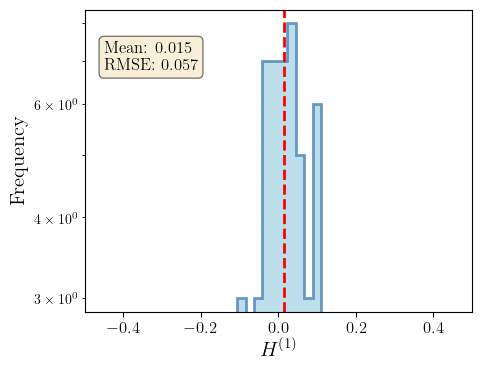

In [6]:
# visualizing inferred fields

# calculate the mean and RMSE of the data
mean = np.mean(fields)
rmse = np.sqrt((fields**2).mean())

# create the histogram
plt.figure(figsize=(5,4), dpi=100)
plt.hist(fields,
         log=True,
         bins=10, 
         histtype='stepfilled', 
         color='lightblue', 
         edgecolor='steelblue',
         linewidth=2,
         alpha=0.8)


# add a vertical line to represent the mean
plt.axvline(mean, color='r', linestyle='dashed', linewidth=2)

# setting labels and ticks
plt.ylabel('Frequency', fontsize=15)
plt.xlabel(r'$H^{(1)}$', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([-0.5, 0.5])

# display the mean and RSME in a text box within the graph
textstr = f'Mean: {mean:.3f}\nRMSE: {rmse:.3f}'
plt.text(0.05, 0.8, 
         textstr, 
         transform=plt.gca().transAxes, 
         fontsize=12, 
         bbox=dict(boxstyle='round', edgecolor='k', facecolor='wheat', alpha=0.5))


# show the plot
plt.show()

## Inferring 2-body couplings

Analogously, the expression for the 2-body couplings is given by

$$
J_{j_1 j_2}^{(2)} = \frac{1}{4} \sum_i \mathbb{E}_{X_i^{(j_1 j_2)}} \left[ \ln \frac{ \cosh \left( \theta_i + w_{i j_1} + w_{i j_2} + X_i^{\left( j_1 j_2 \right)} \right) \cosh \left( \theta_i - ( w_{i j_1} + w_{i j_2} ) + X_i^{\left( j_1 j_2 \right)} \right)}{ \cosh \left( \theta_i + (w_{i j_1} - w_{i j_2}) + X_i^{\left( j_1 j_2 \right)} \right) \cosh \left( \theta_i - ( w_{i j_1} - w_{i j_2} ) + X_i^{\left( j_1 j_2 \right)} \right) } \right], \tag{6}
$$

where
$
X_i^{\left( j_1 j_2 \right)} \sim \mathcal{N} \left(0, \sum_{\mu = 3}^{N_v} w_{ij_\mu}^2 \right).
$

In [7]:
# functions

def arg_func2(x, i, j1, j2, w, θ):
    """
    A function to compute the argument of the average in the Eq. (6)
    """    
    return np.log((np.cosh(θ[i] + (w[i,j1]+w[i,j2]) + x)*np.cosh(θ[i] - (w[i,j1]+w[i,j2]) + x)) 
                  / (np.cosh(θ[i] + (w[i,j1]-w[i,j2]) + x)*np.cosh(θ[i] - (w[i,j1]-w[i,j2]) + x))
                 )

def est_expect2(i, j1, j2, w, θ, α=15, Δx=0.1):
    """
    For a given index i, it computes the average in the Eq. (6) using the simpson's rule.
    
    params:
    - α: it sets the domain of the numerical integration to [-α, α]
    - Δx: the step size of the numerical integration
    """
    
    # setting the domain of the numerical integral
    n_steps = int(2*α*(1/Δx))
    x = np.linspace(-α, α, n_steps)

    # computing the sd of the probability function
    sd = np.linalg.norm(np.delete(w[i,:], 
                                  [j1, j2]))
    
    # returns the results of the numerical integration
    return simps(arg_func2(x, i, j1, j2, w, θ)
                 * norm.pdf(x, loc=0, scale=sd), x)

def est_J2(j1, j2, w, θ):
    """
    Given the parameters of an RBM, it computes the r.h.s. of Eq. (6) 
    """
    Nh = θ.size 
    return 0.25*np.sum([est_expect2(i, j1, j2, w, θ) for i in range(Nh)], axis=0)

In [8]:
# extracting couplings (2nd order)
Nv = w.shape[1]
couplings = np.zeros((Nv, Nv))
# print(couplings)
for j1 in range(1, Nv):
    for j2 in range(j1):
        couplings[j1, j2] = est_J2(j1, j2, w, θ)

# this cell runs in ~20s

In [9]:
# retrieving coupling information from the training data file
file_name = 'Ising_samples/2D_EAmodel_β=0.2_L=7_M=100000.h5'
with h5py.File(file_name, 'r') as f:
    data_couples = f['couples'][:]
    data_couplings = f['couplings'][:]

# Creating data matrix
L=7
N = L**2
β=0.2
data_couplings_matrix = np.zeros((N, N))
    
for sites, J in zip(data_couples, data_couplings):
    j1, j2 = np.sort(sites)
    data_couplings_matrix[j1, j2] = β*J

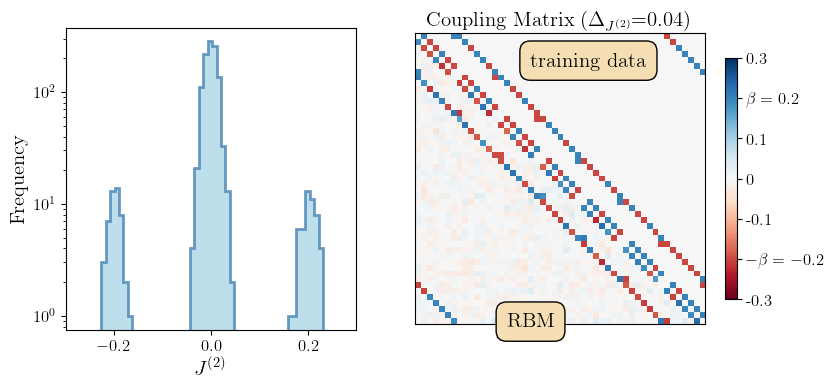

In [10]:
# visualizing infered 2-body couplings

fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=100)
ax0, ax1 = axs.flat

# histograms
subdiag_indexes = np.tril_indices(couplings.shape[0], -1)
ax0.hist(couplings[subdiag_indexes].flatten(),
            bins=50,
            log=True,
            histtype='stepfilled',
            color='lightblue',
            edgecolor='steelblue',
            linewidth=2,
            alpha=0.8
            )

# setting titles, ticks and labels
ax0.set_xlabel(r'$J^{(2)}$', fontsize=15)  # Set x-axis label
ax0.set_ylabel('Frequency', fontsize=15)  # Set y-axis label
ax0.tick_params(axis='both', labelsize=12)
ax0.set_xlim([-0.3, 0.3])

# computing the error
ΔJ_2D = np.sqrt(np.sum((couplings- data_couplings_matrix.T)**2)
                / np.sum(data_couplings.T**2))

# matrices
c2plot = couplings + data_couplings_matrix
plot = axs[1].imshow(c2plot,
                     cmap='RdBu',
                     vmin=0.3,
                     vmax=-0.3,
                     )

# setting titles, ticks and labels
ax1.set_title('Coupling Matrix ' 
              + r'($\Delta_{J^{(2)}}$'
              + fr'={np.round(ΔJ_2D, 2)})', 
              fontsize=15)

ax1.set_xticks([])  # Hide x-axis ticks
ax1.set_yticks([])  # Hide y-axis ticks
ax1.set_xticklabels([])  # Remove x-axis tick labels
ax1.set_yticklabels([])  # Remove y-axis tick labels

# adding the text boxes
ax1.text(19,5, "training data", 
         fontsize=15,
         bbox=dict(facecolor='wheat', edgecolor='k', boxstyle='round,pad=0.5'))
ax1.text(15,49, 
         'RBM', 
         fontsize=15,
         bbox=dict(facecolor='wheat', edgecolor='k', boxstyle='round,pad=0.5'))

# adding a colorbar
cbar = plt.colorbar(plot, 
                    ax=axs.ravel().tolist(), 
                    pad=0.025, 
                    shrink=0.8,
                   )
cbar.set_ticks([-0.3,-0.2,-0.1,0,0.1,0.2,0.3])
cbar.set_ticklabels(['-0.3', r'$-\beta=-0.2$','-0.1','0','0.1',r'$\beta=0.2$','0.3'])
cbar.ax.tick_params(labelsize=12)

#show the plot
plt.show()

### Comparison with previous methods

We also consider that the Eq. (6) in terms of our old parameters $b_j, \ c_i,$ and $W_{ij}$ can be rewritten as

$$
\begin{align}
    &J^{(2)}_{j_1 j_2} 
    = \frac{1}{4} \sum_i \ln \frac{\left( 1 + e^{c_i + W_{i j_1} + W_{i j_2}} \right) \left(1 + e^{c_i} \right)}{\left(1 + e^{c_i + W_{i j_1}} \right) \left(1 + e^{c_i + W_{i j_2}} \right)} \nonumber \\
    & \quad 
    + \frac{1}{4} 
    \sum_i \mathbb{E}_{Y_i^{(j_1 j_2)}}  \ln
    \frac{ 
    { 
    \displaystyle \left[ 1 + \tanh \frac{1}{2}\left( W_{ij_1} + W_{ij_2} + c_i \right) \tanh \frac{1}{4} \left( Y_i^{(j_1 j_2)} + \sum_{j \neq j_1, j_2} W_{ij} \right) \right] }{ 
    \displaystyle \times \left[ 1 + \tanh \left( \frac{c_i}{2} \right) \tanh \frac{1}{4} \left( Y_i^{(j_1 j_2)}+ \sum_{j \neq j_1, j_2} W_{ij} \right) \right] }}
    {{ 
    \displaystyle \left [ 1 + \tanh \frac{1}{2} \left( W_{ij_1} + c_i \right) \tanh \frac{1}{4} \left( Y_i^{(j_1 j_2)} + \sum_{j \neq j_1, j_2} W_{ij} \right) \right ]} 
    {\displaystyle \times \left[ 1 + \tanh \frac{1}{2} \left( W_{ij_2} + c_i \right) \tanh \frac{1}{4} \left( Y_i^{(j_1 j_2)} + \sum_{j \neq j_1, j_2} W_{ij} \right) \right]}} ,
   \tag{7}     
\end{align} 
$$

where 
$
Y_i^{\left( j_1 j_2 \right)} \sim \mathcal{N} \left(0, \sum_{\mu = 3}^{N_v} W_{ij_\mu}^2 \right).
$

Note that the first term of the r.h.s. of the Eq. (7) resembles the formula given by Cossu *et al.* [2] for the inference of 2 body couplings out of an RBM trained with Ising model samples. Thus, the second term accounts for the difference between this formula a ours.

In [11]:
# functions

# formula for the Cossu et al.'s [2] method (i.e., first part of the r.h.s of the Eq. (7))
def est_J2_cossu(j1, j2, W, c):
    """
    Given the parameters of an RBM, it computes first part of the r.h.s. of Eq. (7).
    """
    Nh = c.size
    return 0.25* np.sum([np.log( ( (1 + np.exp(c[i] + W[i,j1] + W[i,j2])) 
                                  * (1 + np.exp(c[i])) ) 
                                /( (1 + np.exp(c[i] + W[i,j1])) 
                                  * (1 + np.exp(c[i] + W[i,j2])) )
                               )
                         # we compute the above expression for every i
                         for i in range(Nh)], axis=0) # and then we sum up all

# formulas for the second part of the r.h.s. of the Eq. (7).
def arg_func2_Δ(y, i, j1, j2, W, c):
    """
    A function to compute the argument of the average in the second part of the r.h.s. of the Eq. (7)
    """   
    W_sum = np.delete(W[i,:], [j1, j2]).sum()
    return np.log( ( (1 + np.tanh((W[i,j1] + W[i,j2] + c[i])*0.5) * np.tanh((y + W_sum)*0.25)) 
                    * (1 + np.tanh(c[i]*0.5) * np.tanh((y + W_sum)*0.25)) 
                   )
                  / ( (1 + np.tanh((W[i,j1] + c[i])*0.5) * np.tanh((y + W_sum)*0.25)) 
                     * (1 + np.tanh((W[i,j2] + c[i])*0.5) * np.tanh((y + W_sum)*0.25)) 
                    )
                 )

def est_expect_Δ(i, j1, j2, W, c, α=100, Δy=1):
    """
    For a given index i, it computes the average in the second part of the 
    Eq. (7) using the simpson's rule.
    
    params:
    - α: it sets the domain of the numerical integration to [-α, α]
    - Δx: the step size of the numerical integration
    """
    # setting the domain of the numerical integral
    n_steps = int(2*α*(1/Δy))
    y = np.linspace(-α, α, n_steps)
    
    # computing the sd of the probability function
    sd = np.linalg.norm(np.delete(W[i,:], 
                                  [j1, j2]))
    
    # returns the results of the numerical integration
    return simps(arg_func2_Δ(y, i, j1, j2, W, c)
                 *norm.pdf(y, loc=0, scale=sd), y)

def est_J2_Δ(j1, j2, W, c):
    """
    Given the parameters of an RBM, it computes the r.h.s. of Eq. (6) 
    """
    H_error = 0
    n = c.shape[0]
    for i in range(n):
        H_error +=  est_expect_Δ(i, j1, j2, W, c)
    return 0.25*H_error

In [12]:
# extracting couplings (2nd order)
Nv = w.shape[1]
couplings_cossu = np.zeros((Nv, Nv))
couplings_Δ = np.zeros((Nv, Nv))
for j1 in range(1, Nv):
    for j2 in range(j1):
        couplings_cossu[j1, j2] = est_J2_cossu(j1, j2, W, c)
        couplings_Δ[j1, j2] = est_J2_Δ(j1, j2, W, c)

# This cell runs in ~25s

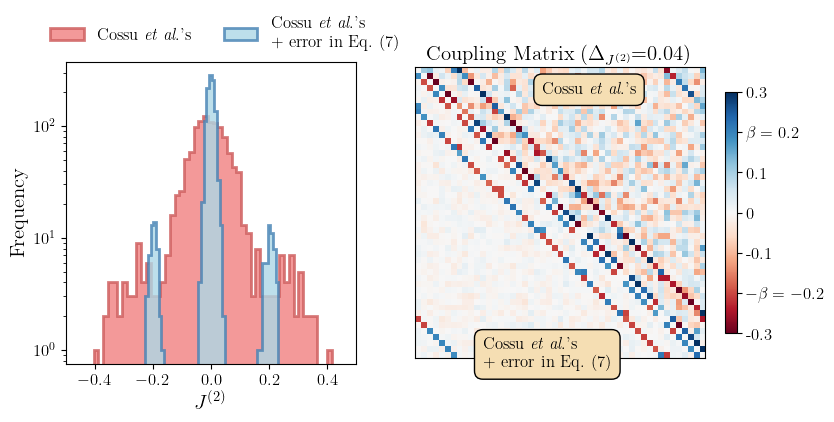

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=100)
ax0, ax1 = axs.flat

couplings_cossu_plus_Δ = (couplings_cossu 
                          + couplings_Δ)

# histogram
subdiag_indexes = np.tril_indices(couplings.shape[0], -1)
ax0.hist(couplings_cossu[subdiag_indexes].flatten(),
         bins=50,
         log=True,
         histtype='stepfilled',
         color='lightcoral',
         edgecolor='indianred',
         linewidth=2,
         alpha=0.8,
         label="Cossu $\emph{et al}.$'s"
        )
ax0.hist(couplings_cossu_plus_Δ[subdiag_indexes].flatten(),
         bins=50,
         log=True,
         histtype='stepfilled',
         color='lightblue',
         edgecolor='steelblue',
         linewidth=2,
         alpha=0.8,
         label = (r"Cossu $\emph{et al}.$'s" + "\n" 
                  + "+ error in Eq. (7)")
        )

# setting titles, ticks and labels
ax0.set_xlabel(r'$J^{(2)}$', fontsize=15)  # Set x-axis label
ax0.set_ylabel('Frequency', fontsize=15)  # Set y-axis label
ax0.tick_params(axis='both', labelsize=12)
ax0.set_xlim([-0.5, 0.5])
ax0.legend(bbox_to_anchor=(1.2, 1.2), 
           fontsize=12,
           ncol=2,
           frameon=False
          )

# matrices
c2plot = couplings_cossu_plus_Δ + couplings_cossu.T
plot = axs[1].imshow(c2plot,
                     cmap='RdBu',
                     vmin=0.3,
                     vmax=-0.3,
                     )

# setting titles, ticks and labels
ax1.set_title('Coupling Matrix ' 
              + r'($\Delta_{J^{(2)}}$'
              + fr'={np.round(ΔJ_2D, 2)})', 
              fontsize=15)

ax1.set_xticks([])  # Hide x-axis ticks
ax1.set_yticks([])  # Hide y-axis ticks
ax1.set_xticklabels([])  # Remove x-axis tick labels
ax1.set_yticklabels([])  # Remove y-axis tick labels

# adding the text boxes
ax1.text(21,4, "Cossu $\emph{et al}.$'s", 
         fontsize=12,
         bbox=dict(facecolor='wheat', edgecolor='k', boxstyle='round,pad=0.5'))
ax1.text(11,50, 
         (r"Cossu $\emph{et al}.$'s" + "\n" 
                  + "+ error in Eq. (7)"), 
         fontsize=12,
         bbox=dict(facecolor='wheat', edgecolor='k', boxstyle='round,pad=0.5'))

# adding a colorbar
cbar = plt.colorbar(plot, 
                    ax=axs.ravel().tolist(), 
                    pad=0.025, 
                    shrink=0.8,
                   )
cbar.set_ticks([-0.3,-0.2,-0.1,0,0.1,0.2,0.3])
cbar.set_ticklabels(['-0.3', r'$-\beta=-0.2$','-0.1','0','0.1',r'$\beta=0.2$','0.3'])
cbar.ax.tick_params(labelsize=12)

#show the plot
plt.show()

## References

[1] Decelle, A., Furtlehner, C., Navas Gómez, A. J., & Seoane, B. (2023). *Inferring effective couplings with Restricted Boltzmann Machines.* arXiv preprint arXiv:2309.02292.

[2] Cossu, G., Del Debbio, L., Giani, T., Khamseh, A., & Wilson, M. (2019). *Machine learning determination of dynamical parameters: The Ising model case.* Physical Review B, 100(6), 064304.